In [1]:
# Import necessary libraries

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import Keras model and layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation

# Import convolutional layers
from keras.layers import Conv2D
from keras.layers import MaxPooling2D

print(tf.__version__)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import splitfolders
import os
import shutil

2.18.0


In [3]:
from PIL import Image
import os
import pathlib

def remove_corrupted_files(in_data_dir):
    in_data_dir = pathlib.Path(in_data_dir)
    removed_files = 0
    for folder in os.listdir(in_data_dir):
        folder_path = in_data_dir / folder
        for image_file in os.listdir(folder_path):
            file_path = folder_path / image_file
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verify if the image is corrupted
            except Exception as e:
                print(f"Removing corrupted file: {file_path} (Error: {e})")
                os.remove(file_path)
                removed_files += 1
    print(f"Completed: Removed {removed_files} corrupted files.\n")

# Call the function
in_data_dir = '/Users/sindhujaarivukkarasu/Documents/ML Zoomcamp-Capstone-2/Grapevine_Leaves_Image_Dataset'
remove_corrupted_files(in_data_dir)


Completed: Removed 0 corrupted files.



In [5]:
import hashlib

def remove_duplicate_files(in_data_dir):
    in_data_dir = pathlib.Path(in_data_dir)
    seen_hashes = set()
    removed_files = 0
    for folder in os.listdir(in_data_dir):
        folder_path = in_data_dir / folder
        for image_file in os.listdir(folder_path):
            file_path = folder_path / image_file
            try:
                # Compute hash of the image
                with open(file_path, "rb") as f:
                    file_hash = hashlib.md5(f.read()).hexdigest()
                if file_hash in seen_hashes:
                    print(f"Removing duplicate file: {file_path}")
                    os.remove(file_path)
                    removed_files += 1
                else:
                    seen_hashes.add(file_hash)
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
    print(f"Completed: Removed {removed_files} duplicate files.\n")

# Call the function
remove_duplicate_files(in_data_dir)


Completed: Removed 0 duplicate files.



In [7]:
from PIL import Image
import pathlib

def check_blank_images(in_data_dir):
    blank_images = []
    for folder in os.listdir(in_data_dir):
        folder_path = pathlib.Path(in_data_dir) / folder
        for image_file in os.listdir(folder_path):
            try:
                with Image.open(folder_path / image_file) as img:
                    img_array = list(img.getdata())  # Flatten the pixel values
                    if all(pixel == img_array[0] for pixel in img_array):
                        blank_images.append(str(folder_path / image_file))
            except Exception as e:
                print(f"Error processing file {image_file}: {e}")

    if blank_images:
        print(f"Found {len(blank_images)} blank images:")
        for blank_image in blank_images:
            print(f"  {blank_image}")
    else:
        print("No blank images found in the dataset.")

# Run the function
check_blank_images(in_data_dir)


No blank images found in the dataset.


In [9]:
import cv2

def remove_blurry_images(in_data_dir, threshold=100):
    in_data_dir = pathlib.Path(in_data_dir)
    removed_files = 0
    for folder in os.listdir(in_data_dir):
        folder_path = in_data_dir / folder
        for image_file in os.listdir(folder_path):
            file_path = folder_path / image_file
            try:
                # Read the image
                img = cv2.imread(str(file_path), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Compute Laplacian variance
                    variance = cv2.Laplacian(img, cv2.CV_64F).var()
                    if variance < threshold:
                        print(f"Removing blurry file: {file_path} (Variance: {variance})")
                        os.remove(file_path)
                        removed_files += 1
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
    print(f"Completed: Removed {removed_files} blurry images.\n")

# Call the function
remove_blurry_images(in_data_dir)


Completed: Removed 0 blurry images.



In [11]:
from PIL import Image
from collections import Counter

def analyze_image_properties(in_data_dir):
    dimensions = []
    file_types = []
    color_modes = []
    
    for folder in os.listdir(in_data_dir):
        folder_path = pathlib.Path(in_data_dir) / folder
        for image_file in os.listdir(folder_path):
            try:
                with Image.open(folder_path / image_file) as img:
                    dimensions.append(img.size)  # (width, height)
                    file_types.append(img.format)  # File type (JPEG, PNG, etc.)
                    color_modes.append(img.mode)  # Color mode (RGB, RGBA, L, etc.)
            except Exception as e:
                print(f"Error reading file {image_file}: {e}")
    
    # Analyze Dimensions
    print("Most common dimensions (Top 5):")
    for dim, count in Counter(dimensions).most_common(5):
        print(f"  {dim}: {count} images")

    # Analyze File Types
    print("\nFile types distribution:")
    for ftype, count in Counter(file_types).items():
        print(f"  {ftype}: {count} images")
    
    # Analyze Color Modes
    print("\nColor modes distribution:")
    for mode, count in Counter(color_modes).items():
        print(f"  {mode}: {count} images")

    # Check if all images are in RGB format
    if all(mode == "RGB" for mode in color_modes):
        print("\nAll images are in RGB format.")
    else:
        print("\nNot all images are in RGB format. Check the distribution above.")
    
    print("\nAnalysis Completed.")

# Run the function
analyze_image_properties(in_data_dir)


Most common dimensions (Top 5):
  (511, 511): 500 images

File types distribution:
  PNG: 500 images

Color modes distribution:
  RGBA: 500 images

Not all images are in RGB format. Check the distribution above.

Analysis Completed.


All images are in RGBA (Red, Green, Blue, Alpha). For most deep learning models, the images need to be converted to RGB because the alpha channel isn't used.

## Convert RGBA to RGB: 

In [15]:
def convert_rgba_to_rgb(in_data_dir, out_data_dir):
    in_data_dir = pathlib.Path(in_data_dir)
    out_data_dir = pathlib.Path(out_data_dir)
    out_data_dir.mkdir(parents=True, exist_ok=True)

    for folder in os.listdir(in_data_dir):
        folder_path = in_data_dir / folder
        out_folder = out_data_dir / folder
        out_folder.mkdir(parents=True, exist_ok=True)

        for image_file in os.listdir(folder_path):
            try:
                with Image.open(folder_path / image_file) as img:
                    # Convert RGBA to RGB
                    img = img.convert("RGB")
                    img.save(out_folder / image_file)
            except Exception as e:
                print(f"Error processing file {image_file}: {e}")

# Example usage
convert_rgba_to_rgb('/Users/sindhujaarivukkarasu/Documents/ML Zoomcamp-Capstone-2/Grapevine_Leaves_Image_Dataset', '/Users/sindhujaarivukkarasu/Documents/ML Zoomcamp-Capstone-2/Converted_Dataset')


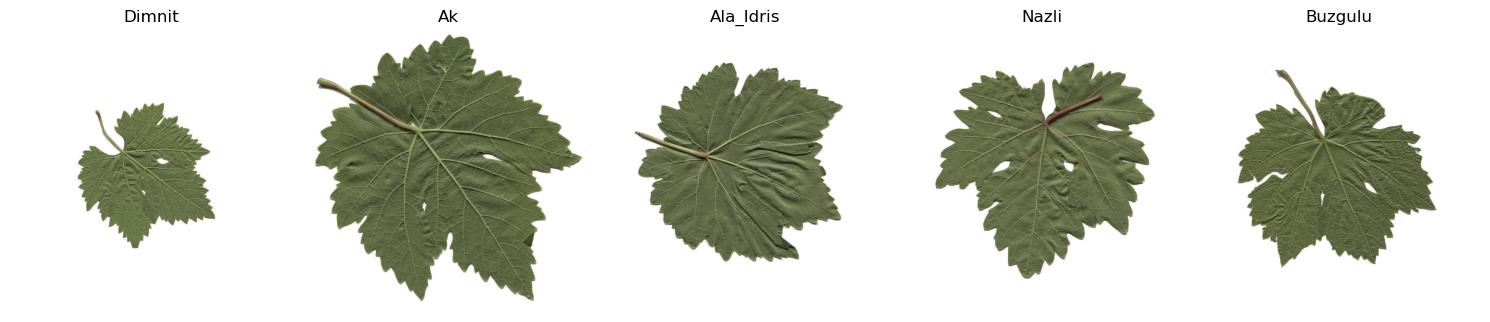

In [17]:
import pathlib
import random
from PIL import Image
import matplotlib.pyplot as plt

def display_one_image_per_folder(in_data_dir):
    in_data_dir = pathlib.Path(in_data_dir)
    folders = [folder for folder in in_data_dir.iterdir() if folder.is_dir()]
    
    fig, axes = plt.subplots(1, len(folders), figsize=(15, 5))
    for i, folder in enumerate(folders):
        # Pick a random image from the folder
        image_file = random.choice(list(folder.glob("*.*")))
        with Image.open(image_file) as img:
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(folder.name)
    
    plt.tight_layout()
    plt.show()

# Example usage
display_one_image_per_folder('/Users/sindhujaarivukkarasu/Documents/ML Zoomcamp-Capstone-2/Converted_Dataset')


Number of images in each class:
  Dimnit: 100 images
  Ak: 100 images
  Ala_Idris: 100 images
  Nazli: 100 images
  Buzgulu: 100 images


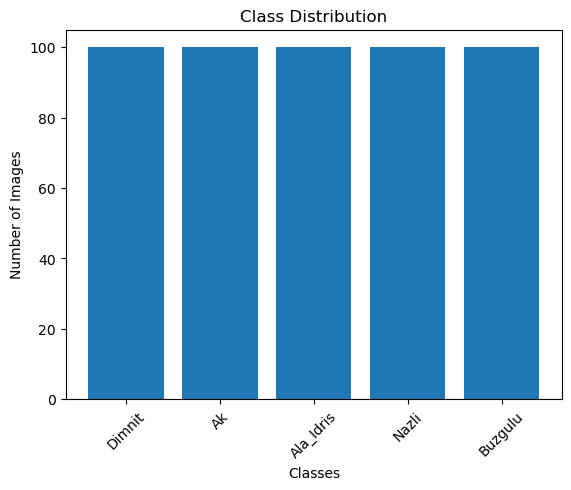

In [19]:
import matplotlib.pyplot as plt
import pathlib

def plot_class_distribution(in_data_dir):
    in_data_dir = pathlib.Path(in_data_dir)
    class_counts = {folder.name: len(list(folder.glob("*.*"))) for folder in in_data_dir.iterdir() if folder.is_dir()}

    # Print the number of images in each class
    print("Number of images in each class:")
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} images")
    
    # Plot the class distribution
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()

# Example usage
plot_class_distribution('/Users/sindhujaarivukkarasu/Documents/ML Zoomcamp-Capstone-2/Converted_Dataset')


In [23]:
from PIL import Image
from collections import Counter

def analyze_image_properties(in_data_dir):
    dimensions = []
    file_types = []
    color_modes = []
    
    for folder in os.listdir(in_data_dir):
        folder_path = pathlib.Path(in_data_dir) / folder
        for image_file in os.listdir(folder_path):
            try:
                with Image.open(folder_path / image_file) as img:
                    dimensions.append(img.size)  # (width, height)
                    file_types.append(img.format)  # File type (JPEG, PNG, etc.)
                    color_modes.append(img.mode)  # Color mode (RGB, RGBA, L, etc.)
            except Exception as e:
                print(f"Error reading file {image_file}: {e}")
    
    # Analyze Dimensions
    print("Most common dimensions (Top 5):")
    for dim, count in Counter(dimensions).most_common(5):
        print(f"  {dim}: {count} images")

    # Analyze File Types
    print("\nFile types distribution:")
    for ftype, count in Counter(file_types).items():
        print(f"  {ftype}: {count} images")
    
    # Analyze Color Modes
    print("\nColor modes distribution:")
    for mode, count in Counter(color_modes).items():
        print(f"  {mode}: {count} images")

    # Check if all images are in RGB format
    if all(mode == "RGB" for mode in color_modes):
        print("\nAll images are in RGB format.")
    else:
        print("\nNot all images are in RGB format. Check the distribution above.")
    
    print("\nAnalysis Completed.")

# Run the function
in_data_dir='/Users/sindhujaarivukkarasu/Documents/ML Zoomcamp-Capstone-2/Converted_Dataset'
analyze_image_properties(in_data_dir)


Most common dimensions (Top 5):
  (511, 511): 500 images

File types distribution:
  PNG: 500 images

Color modes distribution:
  RGB: 500 images

All images are in RGB format.

Analysis Completed.
